# Characterizing the Hypergraph-of-Entity with Context

This representation model uses a weighted mixed hypergraph. Dependending on the version, the weights can be unitary constants. All versions combine directed and undirected hyperedges.

Possible node classes include:

- TermNode
- EntityNode

Possible hyperedge classes include:

- DocumentEdge
- ContainedInEdge
- RelatedToEdge
- SynonymEdge
- ContextEdge

In order to run the notebook, you must first obtain the corresponding CSV files through the `inspect` command in Army ANT. For example:

```bash
./army-ant.py inspect \
    --index-location=/opt/army-ant/indexes/inex-2009-10t-nl/hgoe \
    --index-type=hgoe \
    --workdir=/opt/army-ant/analysis/inex_2009_10t_nl-stats \
    --feature=export-node-degrees
```

You must then put the resulting files into the `data` directory for the collection and index version. For example `data/inex_2009_10t_nl/base_model` for the Hypergraph-of-Entity Base Model over the INEX 2009 3T-NL subset test collection. You should then configure the `base_dir` below accordingly. Bash scripts are provided in directory `runs/inex-2009-10t-nl/hgoe/nb-characterization`, in order to generate the required files.

In [62]:
if (!require("pacman")) install.packages("pacman")

pacman::p_load(
    logging,
    ggplot2,
    scales,
    repr,
    stringr,
    dplyr,
    xtable
)

basicConfig()
options(warn=-1)
options(scipen=0)
options(xtable.include.rownames=FALSE)

base_dir <- "data/inex_2009_10t_nl/context"

## Node degree and hyperedge cardinality distributions

We define a degree data loading function for a given `base_dir`, beautifying the node and hyperedge type labels (i.e., transforming from the Java class identifier to the node or hyperedge label used in the theory).

In [63]:
load_node_degree_data <- function(base_dir) {
    nodes_path <- file.path(base_dir, list.files(path = base_dir, pattern = "node-degree-.*\\.csv"))

    nodes <- setNames(
        read.csv(nodes_path, stringsAsFactors = F),
        c("node_id", "type", "name", "v_degree", "e_degree", "in_v_degree", "out_v_degree",
          "in_e_degree", "out_e_degree", "dir_in_v_degree", "dir_out_v_degree",
          "dir_in_e_degree", "dir_out_e_degree"))
    
    nodes[which(nodes$type == "EntityNode"), "type"] <- "entity"
    nodes[which(nodes$type == "TermNode"), "type"] <- "term"
 
    nodes
}

load_edge_cardinality_data <- function(base_dir) {
    edges_path <- file.path(base_dir, list.files(path = base_dir, pattern = "edge-cardinality-.*\\.csv"))

    edges <- setNames(
        read.csv(edges_path, stringsAsFactors = F),
        c("edge_id", "type", "is_directed", "cardinality", "undirected_cardinality",
          "tail_cardinality", "head_cardinality"))
    
    edges$is_directed <- edges$is_directed == "true"
    
    edges[which(edges$type == "DocumentEdge"), "type"] <- "document"
    edges[which(edges$type == "ContainedInEdge"), "type"] <- "contained_in"
    edges[which(edges$type == "RelatedToEdge"), "type"] <- "related_to"
    edges[which(edges$type == "SynonymEdge"), "type"] <- "synonym"
    edges[which(edges$type == "ContextEdge"), "type"] <- "context"
 
    edges
}

A hypergraph has two degree distributions, one for the nodes and another one for the hyperedges. We look at both.

In [64]:
node_degree <- load_node_degree_data(file.path(base_dir, "global"))
head(node_degree)

node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,entity,Beatrix Schuba,853,3,853,853,3,2,2,0,1,0
1,entity,Gabriele Seyfert,853,3,853,853,3,2,1,0,1,0
2,entity,Mao Asada,1778,9,1778,1778,9,8,2,0,1,0
3,entity,Petra Burka,3615,5,3615,3615,5,4,2,0,1,0
4,entity,Dianne de Leeuw,854,3,854,853,3,2,2,0,1,0
5,entity,Dorothy Hamill,853,2,853,853,2,2,0,0,0,0


In [65]:
edge_cardinality <- load_edge_cardinality_data(file.path(base_dir, "global"))
head(edge_cardinality)
edge_cardinality %>%
    group_by(type) %>%
    summarise(max_cardinality=max(cardinality))

edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
0,document,FALSE,853,853,0,0
1,related_to,FALSE,178,178,0,0
2,document,FALSE,755,755,0,0
3,related_to,FALSE,181,181,0,0
4,document,FALSE,364,364,0,0
5,related_to,FALSE,20,20,0,0


type,max_cardinality
<chr>,<int>
contained_in,16
context,156
document,8167
related_to,3084


We define a degree plotting function that takes the raw CSV, calculates the degree frequency and displays a point plot with a facet for each node or hyperedge type.

In [121]:
plot_degree_per_type <- function(data, label, name="degree") {
    data <- node_degree %>%
        count(type, !!sym(name), sort=TRUE)

    ggplot(data, aes_string(x=name, y="n")) +
        facet_wrap(~type) +
        geom_point(size=0.5) +
        scale_x_log10() + 
        scale_y_log10(limits=c(1,max(data$Freq))) +
        xlab(label) +
        ylab("Frequency")
}

### Node degree distributions

As we can see, the node node degree distribution in the hypergraph-of-entity does not follow a power law, despite having a long tail.

In [122]:
options(repr.plot.width=4.5, repr.plot.height=2)

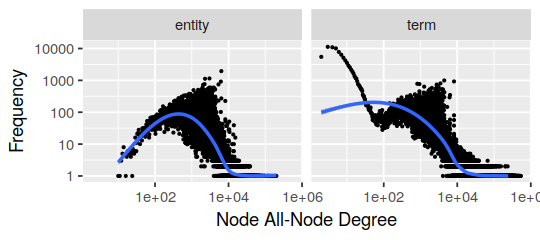

In [123]:
plot_degree_per_type(node_degree, "Node All-Node Degree", "v_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/context/node_all_node_degree.png", width = 4.5, height = 2, dpi = 300)

However, the hyperedge node degree distribution, slightly approximates a power law.

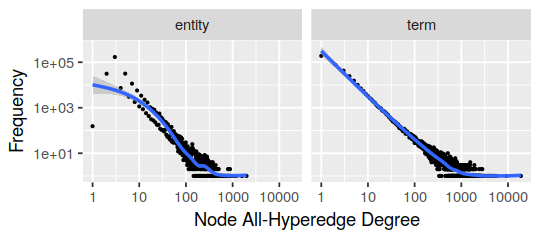

In [124]:
plot_degree_per_type(node_degree, "Node All-Hyperedge Degree", "e_degree") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/context/node_all_hyperedge_degree.png", width = 4.5, height = 2, dpi = 300)

#### Node degree distributions based on directed hyperedges

If we only consider directed hyperedges, the node incoming-node degree does not follow a power law.

In [70]:
options(repr.plot.width=3, repr.plot.height=3)

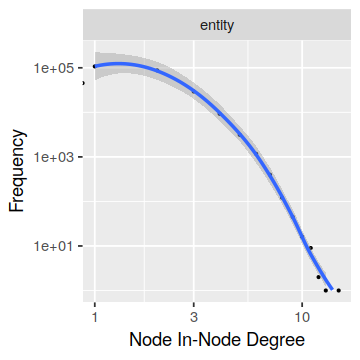

In [71]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Node Degree", "dir_in_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree approximates a power law, although it is more heavy-tailed.

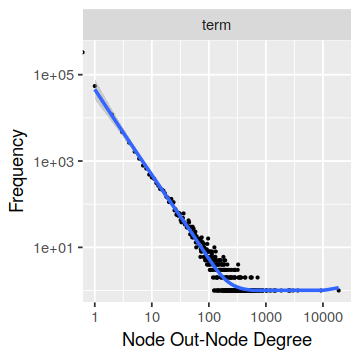

In [72]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Node Degree", "dir_out_v_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node incoming-hyperedge degree is always one.

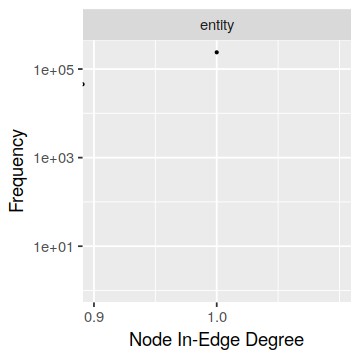

In [73]:
plot_degree_per_type(node_degree[node_degree$type == "entity", ], "Node In-Edge Degree", "dir_in_e_degree") +
    stat_smooth(method = "loess")

For directed hyperedges, the node outgoing-node degree, approximates a power law, although it is more heavy-tailed.

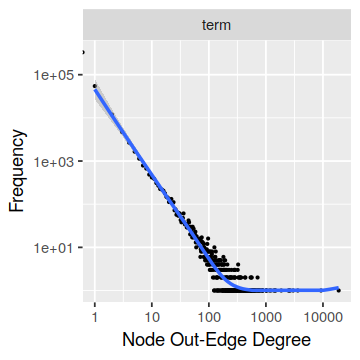

In [74]:
plot_degree_per_type(node_degree[node_degree$type == "term", ], "Node Out-Edge Degree", "dir_out_e_degree") +
    stat_smooth(method = "loess")

### Hyperedge cardinality distributions

The hyperedge cardinality distributions do not follow power laws, with the `contained_in` hyperedges having less nodes than `document` or `related_to` hyperedges. This is expected, as `contained_in` hyperedges usually link a few `term` nodes to its corresponding `entity` node.

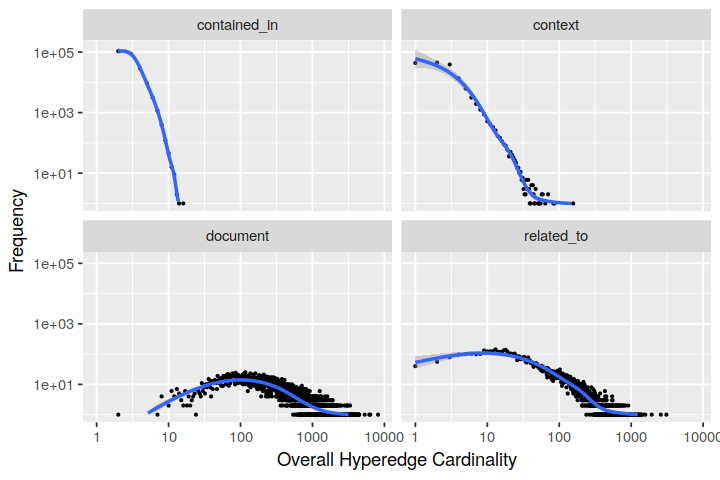

In [75]:
options(repr.plot.width=6, repr.plot.height=4)
plot_degree_per_type(edge_cardinality, "Overall Hyperedge Cardinality", "cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))
ggsave(filename = "output/context/hyperedge_overall_cardinality.png", width = 6, height = 4, dpi = 300)

#### Hyperedge cardinality distribution based on directed hyperedges

If we only consider directed hyperedges, the tail cardinality has the following non-power-law distribution.

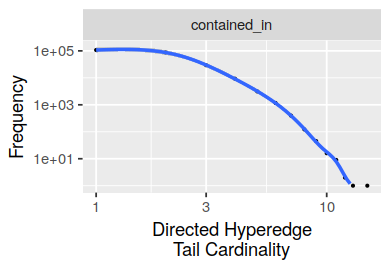

In [76]:
options(repr.plot.width=3.25, repr.plot.height=2.25)
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge\nTail Cardinality", "tail_cardinality") +
    #scale_x_continuous() +
    #scale_y_continuous() +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

For directed hyperedges, the head cardinality is always one.

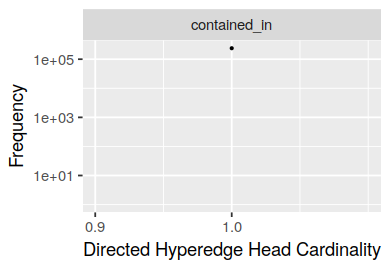

In [77]:
plot_degree_per_type(edge_cardinality[edge_cardinality$type == "contained_in", ],
                     "Directed Hyperedge Head Cardinality", "head_cardinality") +
    stat_smooth(method = "gam", formula = y ~ s(x, bs = "cs"))

## Top 10 nodes

### Node incoming-node degree

In [78]:
top_10_terms_by_incoming_node_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_terms_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
458,also,537951
734,new,522931
525,on,512256
985,first,509026
1062,time,492092
1053,refer,484453
573,see,482742
775,state,478665
687,link,475904


In [79]:
top_10_entities_by_incoming_node_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_v_degree=sum(in_v_degree)) %>%
    arrange(desc(in_v_degree)) %>%
    head(10)
top_10_entities_by_incoming_node_degree

node_id,name,in_v_degree
<int>,<chr>,<int>
1169,United States,199796
425,India,174817
107,Japan,154539
8616,France,146492
3889,2007,136161
8738,World War II,134358
4860,Germany,133949
3891,2006,130566
201,Russia,126066


### Node incoming-hyperedge degree

In [80]:
top_10_terms_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "term") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_terms_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
458,also,5386
1053,refer,4701
687,link,4558
686,extern,4464
525,on,4419
734,new,4202
985,first,4095
1062,time,4009
573,see,3997


In [81]:
top_10_entities_by_incoming_hyperedge_degree <- node_degree %>%
    filter(type == "entity") %>%
    group_by(node_id) %>%
    summarise(name=max(name), in_e_degree=sum(in_e_degree)) %>%
    arrange(desc(in_e_degree)) %>%
    head(10)
top_10_entities_by_incoming_hyperedge_degree

node_id,name,in_e_degree
<int>,<chr>,<int>
1169,United States,1984
4086,Scientific classification,1596
425,India,1587
107,Japan,1205
4065,Dinosaur,1129
3889,2007,1009
3891,2006,1005
8616,France,984
4860,Germany,922


## Global statistics

In [82]:
load_stats_data <- function(base_dir, as_list=FALSE) {
    stats_path <- file.path(base_dir, list.files(path = base_dir, pattern = "stats-.*\\.csv"))

    stats <- read.csv(stats_path, stringsAsFactors = F)
    
    stats
}

In [83]:
stats <- rbind(
    load_stats_data(file.path(base_dir, "global")),
    data.frame(
        Statistic=c(
            "Term Vertices",
            "Entity Vertices",
            "contained_in Hyperedges",
            "document Hyperedges",
            "related_to Hyperedges"
        ),
        Value=c(
            nrow(node_degree[node_degree$type == "term", ]),
            nrow(node_degree[node_degree$type == "entity", ]),
            nrow(edge_cardinality[edge_cardinality$type == "contained_in", ]),
            nrow(edge_cardinality[edge_cardinality$type == "document", ]),
            nrow(edge_cardinality[edge_cardinality$type == "related_to", ])
        )
    ))
stats
#print(xtable(stats, digits = 10))

Statistic,Value
<chr>,<dbl>
Vertices,6.970680e+05
Directed Hyperedges,2.382160e+05
Undirected Hyperedges,1.721550e+05
Total Hyperedges,4.103710e+05
Num Sources,0.000000e+00
Num Sinks,0.000000e+00
Density,2.749931e-06
Avg. Degree,1.177420e+00
Min InEdge Degree,1.000000e+00


## Scalability

In order to better understand the impact of adding more documents and entities to the index, we created several snapshots by limiting the number of documents read from INEX 2009 3T-NL subset test collection. We then obtained the following aggregated statistics from each snapshot studying their evolution for an increasing number of documents:

- Average node degree;
 - Average node incoming edge degree;
 - Average node outgoing edge degree;
 - Average node incoming node degree;
 - Average node outgoing node degree;
- Average hyperedge cardinality;
 - Average cardinality for undirected hyperedges;
 - Average tail cardinality for directed hyperedges;
 - Average head cardinality for directed hyperedges;
- Estimated clustering coefficient;
- Estimated average path length and diameter;
- General mixed hypergraph density;
- Size and space usage;
 - Number of nodes;
 - Number of hyperedges;
 - Number of bytes in disk;
 - Number of bytes in memory.

We will begin by the node and hyperedge degree. In order to generate the required data, run the scripts in `runs/inex-2009-3t-nl/hgoe/scalability` in order. This will generate indices with a progressively larger number of documents, using the `--limit` argument (snapshots). Inspect will then generate the node and edge degree distributions per index snapshot, properly organizing them in a directory with name `snapshot_<id>_<num_docs>`.

In [84]:
options(repr.plot.width=4, repr.plot.height=2)

In [85]:
load_snapshots_degree_data <- function(base_dir, type="node") {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call(
                paste("load", type, ifelse(type == "node", "degree", "cardinality"), "data", sep="_"),
                list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [86]:
snapshot_node_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="node")
head(snapshot_node_degree)

snapshot_name,snapshot_id,num_docs,node_id,type,name,v_degree,e_degree,in_v_degree,out_v_degree,in_e_degree,out_e_degree,dir_in_v_degree,dir_out_v_degree,dir_in_e_degree,dir_out_e_degree
<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,entity,Cochrane,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,1,entity,Thomas Cochrane,123,2,123,123,2,2,0,0,0,0
snapshot_001_1,001,1,2,entity,Cochrane (disambiguation),123,1,123,123,1,1,0,0,0,0
snapshot_001_1,001,1,3,entity,"Cochrane, Chile",123,3,123,123,3,2,1,0,1,0
snapshot_001_1,001,1,4,entity,"Cochrane, Unorganized, North Part, Ontario",123,3,123,123,3,2,3,0,1,0
snapshot_001_1,001,1,5,entity,Alexander Cochrane,123,2,123,123,2,2,0,0,0,0


In [87]:
snapshot_edge_degree <- load_snapshots_degree_data(file.path(base_dir, "snapshots"), type="edge")
head(snapshot_edge_degree)

snapshot_name,snapshot_id,num_docs,edge_id,type,is_directed,cardinality,undirected_cardinality,tail_cardinality,head_cardinality
<fct>,<fct>,<dbl>,<int>,<chr>,<lgl>,<int>,<int>,<int>,<int>
snapshot_001_1,001,1,0,document,FALSE,123,123,0,0
snapshot_001_1,001,1,1,related_to,FALSE,28,28,0,0
snapshot_001_1,001,1,2,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,3,contained_in,TRUE,4,0,3,1
snapshot_001_1,001,1,4,contained_in,TRUE,2,0,1,1
snapshot_001_1,001,1,5,contained_in,TRUE,2,0,1,1


In [88]:
plot_degree_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(mean=mean(!!sym(stat), na.rm=TRUE))

    ggplot(data, aes(x=num_docs, y=mean)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}
                      
plot_size_over_time <- function(data, label, stat="degree") {
    data <- data %>%
        group_by(num_docs) %>%
        summarize(len=length(!!sym(stat)))

    ggplot(data, aes(x=num_docs, y=len)) +
        geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

### Average node degree

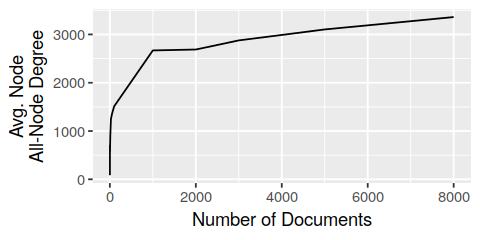

In [89]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Node Degree", stat = "v_degree")
ggsave(filename = "output/context/snapshot_average_all_node_degree.png", width = 4, height = 2, dpi = 300)

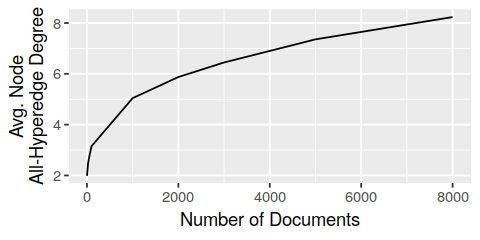

In [90]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node\nAll-Hyperedge Degree", stat = "e_degree")
ggsave(filename = "output/context/snapshot_average_all_hyperedge_degree.png", width = 4, height = 2, dpi = 300)

#### Average node degree based on directed hyperedges

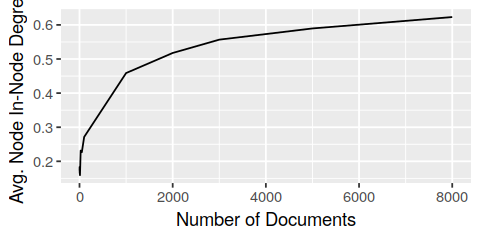

In [91]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Node Degree", stat = "dir_in_v_degree")

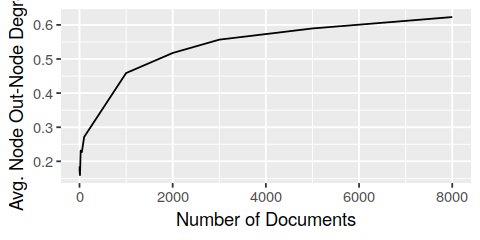

In [92]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Node Degree", stat = "dir_out_v_degree")

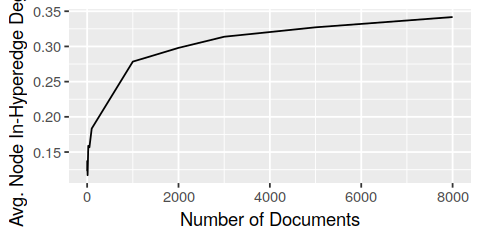

In [93]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node In-Hyperedge Degree", stat = "dir_in_e_degree")

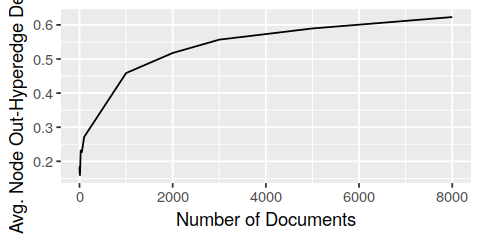

In [94]:
plot_degree_over_time(snapshot_node_degree, "Avg. Node Out-Hyperedge Degree", stat = "dir_out_e_degree")

### Average hyperedge cardinality

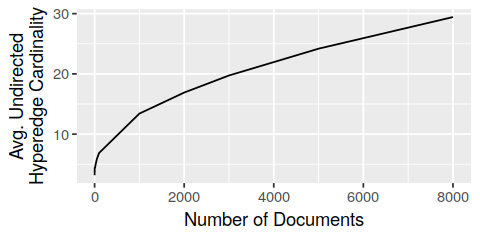

In [95]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(!is_directed), "Avg. Undirected\nHyperedge Cardinality", stat = "cardinality")
ggsave(filename = "output/context/snapshot_average_hyperedge_cardinality.png", width = 4, height = 2, dpi = 300)

In [96]:
snapshot_edge_degree %>%
    filter(!is_directed) %>%
    group_by(num_docs) %>%
    summarise(mean=mean(cardinality, na.rm = TRUE))

num_docs,mean
<dbl>,<dbl>
1,3.185567
2,4.045752
3,4.415332
4,4.349398
5,4.390604
10,4.422393
25,5.031146
50,5.850298
100,6.869988


#### Average directed hyperedge cardinalities

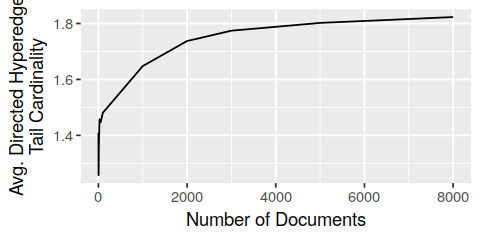

In [97]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nTail Cardinality",
    stat = "tail_cardinality")

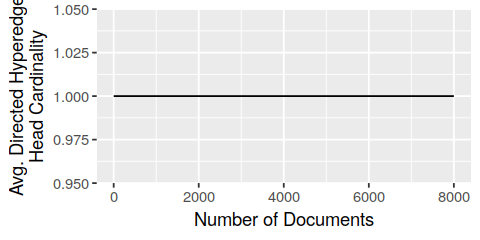

In [98]:
plot_degree_over_time(
    snapshot_edge_degree %>% filter(is_directed),
    "Avg. Directed Hyperedge\nHead Cardinality",
    stat = "head_cardinality")

### Estimated clustering coefficient

In [99]:
load_snapshots_stats_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            do.call("load_stats_data", list(base_dir = snapshot_dir)))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    
    setNames(data, c(names(data)[1:3], "statistic", "value"))
}

In [100]:
snapshot_stats <- load_snapshots_stats_data(file.path(base_dir, "snapshots"))
head(snapshot_stats)

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_001_1,001,1,Vertices,179
snapshot_001_1,001,1,Directed Hyperedges,22
snapshot_001_1,001,1,Undirected Hyperedges,97
snapshot_001_1,001,1,Total Hyperedges,119
snapshot_001_1,001,1,Num Sources,0
snapshot_001_1,001,1,Num Sinks,0


In [101]:
plot_statistics_over_time <- function(data, label, log_scale=FALSE, legend_position = c(0.565, 0.8)) {
    if (length(unique(data$statistic)) > 1) {
        p <- ggplot(data, aes(x=num_docs, y=value, color=statistic)) +
            scale_color_manual("Statistic", values=c("#9673a6", "#82b366")) +
            theme(
                legend.position=legend_position,
                legend.direction="horizontal")
    } else {
        p <- ggplot(data, aes(x=num_docs, y=value))
    }
    
    if (log_scale) {
        p <- p + scale_x_log10() + scale_y_log10()
    }
    
    p + geom_line() +
        xlab("Number of Documents") +
        ylab(label)
}

In [102]:
snapshot_cc <- snapshot_stats[which(snapshot_stats$statistic == "Avg. Clustering Coefficient"), ]
snapshot_cc

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
17,snapshot_001_1,001,1,Avg. Clustering Coefficient,0.4606831
34,snapshot_002_2,002,2,Avg. Clustering Coefficient,0.4590547
51,snapshot_003_3,003,3,Avg. Clustering Coefficient,0.4674458
68,snapshot_004_4,004,4,Avg. Clustering Coefficient,0.4695899
87,snapshot_005_5,005,5,Avg. Clustering Coefficient,0.4546061
104,snapshot_006_10,006,10,Avg. Clustering Coefficient,0.4293002
121,snapshot_007_25,007,25,Avg. Clustering Coefficient,0.3757907
140,snapshot_008_50,008,50,Avg. Clustering Coefficient,0.3458342
157,snapshot_009_100,009,100,Avg. Clustering Coefficient,0.3067597


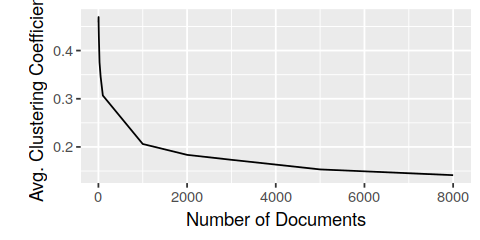

In [103]:
plot_statistics_over_time(snapshot_cc, "\nAvg. Clustering Coefficient")
ggsave(filename = "output/context/snapshot_avg_clustering_coefficient.png", width = 4, height = 2, dpi = 300)

### Estimated average path length and diameter

In [104]:
snapshot_paths <- snapshot_stats[which(snapshot_stats$statistic %in% c("Avg. Path Length", "Diameter")), ]
snapshot_paths %>% filter(statistic == "Diameter")
snapshot_paths %>% filter(statistic == "Avg. Path Length")

snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_004_4,004,4,Diameter,2
snapshot_007_25,007,25,Diameter,4
snapshot_011_2000,011,2000,Diameter,3
snapshot_013_5000,013,5000,Diameter,4
snapshot_014_8000,014,8000,Diameter,3


snapshot_name,snapshot_id,num_docs,statistic,value
<fct>,<fct>,<dbl>,<chr>,<dbl>
snapshot_004_4,004,4,Avg. Path Length,1.600000
snapshot_007_25,007,25,Avg. Path Length,2.066667
snapshot_011_2000,011,2000,Avg. Path Length,2.066667
snapshot_013_5000,013,5000,Avg. Path Length,2.266667
snapshot_014_8000,014,8000,Avg. Path Length,2.000000


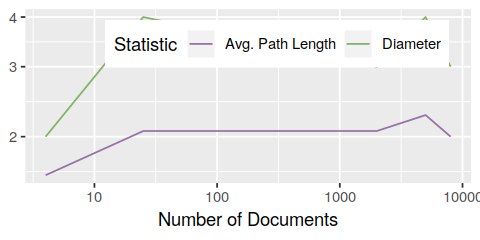

In [105]:
plot_statistics_over_time(snapshot_paths, NULL, log_scale = TRUE)
ggsave(filename = "output/context/snapshot_avg_shortest_path_stats.png", width = 4, height = 2, dpi = 300)

### General mixed hypergraph density

In [106]:
snapshot_density <- snapshot_stats[which(snapshot_stats$statistic == "Density"), ]
snapshot_density

,snapshot_name,snapshot_id,num_docs,statistic,value
,<fct>,<fct>,<dbl>,<chr>,<dbl>
7,snapshot_001_1,001,1,Density,2.762525e-03
24,snapshot_002_2,002,2,Density,2.542963e-04
41,snapshot_003_3,003,3,Density,1.912133e-04
58,snapshot_004_4,004,4,Density,1.770496e-04
77,snapshot_005_5,005,5,Density,1.298780e-04
94,snapshot_006_10,006,10,Density,7.911161e-05
111,snapshot_007_25,007,25,Density,3.250718e-05
130,snapshot_008_50,008,50,Density,2.182150e-05
147,snapshot_009_100,009,100,Density,1.582316e-05


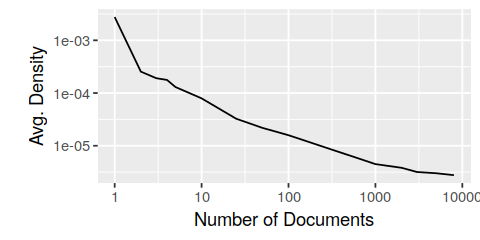

In [107]:
plot_statistics_over_time(snapshot_density, "\nAvg. Density", log_scale = TRUE)
ggsave(filename = "output/context/snapshot_avg_density.png", width = 4, height = 2, dpi = 300)

### Size and space usage

#### Number of nodes and hyperedges

The growth in number of nodes is sublinear in regard to the number of documents.

In [108]:
snapshot_node_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(node_id))

num_docs,len
<dbl>,<int>
1,179
2,1822
3,2272
4,2521
5,3660
10,6683
25,15847
50,23911
100,36168


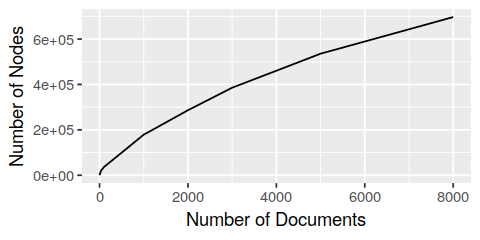

In [109]:
plot_size_over_time(snapshot_node_degree, "Number of Nodes", stat = "node_id")
ggsave(filename = "output/context/snapshot_num_nodes.png", width = 4.5, height = 2, dpi = 300)

Similarly, the growth in number of hyperedges is sublinear in regard to the number of documents, although there are significantly less hyperedges than nodes.

In [110]:
snapshot_edge_degree %>%
        group_by(num_docs) %>%
        summarize(len=length(edge_id))

num_docs,len
<dbl>,<int>
1,119
2,1015
3,1185
4,1330
5,1970
10,3650
25,9099
50,13328
100,20822


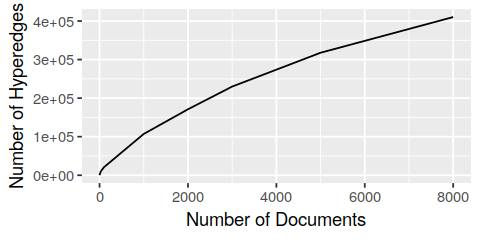

In [111]:
plot_size_over_time(snapshot_edge_degree, "Number of Hyperedges", stat = "edge_id")
ggsave(filename = "output/context/snapshot_num_hyperedges.png", width = 4.5, height = 2, dpi = 300)

#### Number of bytes in disk and memory

In [112]:
load_snapshots_space_usage_data <- function(base_dir) {
    data <- do.call(rbind, lapply(list.files(path = base_dir, include.dirs = TRUE), function(snapshot) {
        snapshot_dir <- file.path(base_dir, snapshot)

        cbind(
            snapshot_name = snapshot,
            snapshot_id = strsplit(snapshot, "_")[[1]][2],
            num_docs = strsplit(snapshot, "_")[[1]][3],
            read.csv(file.path(snapshot_dir, list.files(path = snapshot_dir, pattern = "space-usage-.*\\.csv"))))
    }))
    
    data$num_docs <- as.numeric(as.character(data$num_docs))
    data
}

In [113]:
snapshot_space <- load_snapshots_space_usage_data(file.path(base_dir, "snapshots"))
snapshot_space

snapshot_name,snapshot_id,num_docs,Statistic,Value
<fct>,<fct>,<dbl>,<fct>,<dbl>
snapshot_001_1,001,1,Disk (Bytes),59815
snapshot_001_1,001,1,Memory (Bytes),741684608
snapshot_002_2,002,2,Disk (Bytes),442453
snapshot_002_2,002,2,Memory (Bytes),822084008
snapshot_003_3,003,3,Disk (Bytes),544499
snapshot_003_3,003,3,Memory (Bytes),822084400
snapshot_004_4,004,4,Disk (Bytes),602151
snapshot_004_4,004,4,Memory (Bytes),822215064
snapshot_005_5,005,5,Disk (Bytes),869208


In [114]:
snapshot_space %>%
    filter(Statistic == "Disk (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^2, 1), "MiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

snapshot_space %>%
    filter(Statistic == "Memory (Bytes)") %>%
    summarise(Mean=mean(Value), StdDev=sd(Value)) %>%
    mutate(Mean=paste(round(Mean / 1024^3, 1), "GiB"), StdDev=paste(round(StdDev / 1024^2, 1), "MiB"))

Mean,StdDev
<chr>,<chr>
43 MiB,66.1 MiB


Mean,StdDev
<chr>,<chr>
1.1 GiB,526.5 MiB


In [115]:
plot_space_usage <- function(data, label, stat = "Disk (Bytes)", unit="MB") {
    data <- data %>% filter(Statistic == stat)
    
    stopifnot(unit %in% c("B", "KB", "MB", "GB", "TB"))
    
    if (unit == "B") {
        frac <- 1
    } else if (unit == "KB") {
        frac <- 1024
    } else if (unit == "MB") {
        frac <- 1024^2
    } else if (unit == "GB") {
        frac <- 1024^3
    } else if (unit == "TB") {
        frac <- 1024^4
    }
    
    ggplot(data, aes(x = num_docs, y = Value / frac)) +
        geom_line() +
        scale_y_continuous(label = function(s) paste(s, unit)) +
        xlab("Number of Documents") +
        ylab(label)
}

The growth in disk space is sublinear in regard to the number of documents.

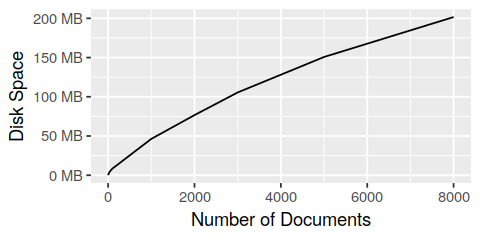

In [116]:
plot_space_usage(snapshot_space, "Disk Space", stat = "Disk (Bytes)")
ggsave(filename = "output/context/snapshot_disk_space.png", width = 4.5, height = 2, dpi = 300)

The growth in memory space is sublinear in regard to the number of documents, presenting a sharper growth for the first 1000 documents.

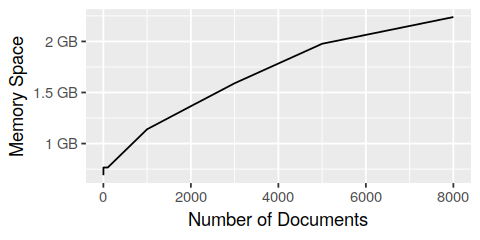

In [117]:
plot_space_usage(snapshot_space, "Memory Space", stat = "Memory (Bytes)", unit = "GB")
ggsave(filename = "output/context/snapshot_mem_space.png", width = 4.5, height = 2, dpi = 300)